# Self made SVD

In [4]:
import helpers
import pandas as pd
import numpy as np
import scipy.sparse as sparse
from collections import defaultdict
from itertools import chain
import random

train_read=pd.read_csv('./Datasets/ml-100k/train.csv', sep='\t', header=None)
test_read=pd.read_csv('./Datasets/ml-100k/test.csv', sep='\t', header=None)
train_ui, test_ui, user_code_id, user_id_code, item_code_id, item_id_code = helpers.data_to_csr(train_read, test_read)

In [13]:
# Done similarly to https://github.com/albertauyeung/matrix-factorization-in-python
from tqdm import tqdm

class SVD():
    
    def __init__(self, train_ui, learning_rate, regularization, nb_factors, iterations):
        self.train_ui=train_ui
        self.uir=list(zip(*[train_ui.nonzero()[0],train_ui.nonzero()[1], train_ui.data]))
        
        self.learning_rate=learning_rate
        self.regularization=regularization
        self.iterations=iterations
        self.nb_users, self.nb_items=train_ui.shape
        self.nb_ratings=train_ui.nnz
        self.nb_factors=nb_factors
        
        self.Pu=np.random.normal(loc=0, scale=1./self.nb_factors, size=(self.nb_users, self.nb_factors))
        self.Qi=np.random.normal(loc=0, scale=1./self.nb_factors, size=(self.nb_items, self.nb_factors))

    def train(self, test_ui=None):
        if test_ui!=None:
            self.test_uir=list(zip(*[test_ui.nonzero()[0],test_ui.nonzero()[1], test_ui.data]))
            
        self.learning_process=[]
        pbar = tqdm(range(self.iterations))
        for i in pbar:
            pbar.set_description(f'Epoch {i} RMSE: {self.learning_process[-1][1] if i>0 else 0}. Training epoch {i+1}...')
            np.random.shuffle(self.uir)
            self.sgd(self.uir)
            if test_ui==None:
                self.learning_process.append([i+1, self.RMSE_total(self.uir)])
            else:
                self.learning_process.append([i+1, self.RMSE_total(self.uir), self.RMSE_total(self.test_uir)])
    
    def sgd(self, uir):
        
        for u, i, score in uir:
            # Computer prediction and error
            prediction = self.get_rating(u,i)
            e = (score - prediction)
            
            # Update user and item latent feature matrices
            Pu_update=self.learning_rate * (e * self.Qi[i] - self.regularization * self.Pu[u])
            Qi_update=self.learning_rate * (e * self.Pu[u] - self.regularization * self.Qi[i])
            
            self.Pu[u] += Pu_update
            self.Qi[i] += Qi_update
        
    def get_rating(self, u, i):
        prediction = self.Pu[u].dot(self.Qi[i].T)
        return prediction
    
    def RMSE_total(self, uir):
        RMSE=0
        for u,i, score in uir:
            prediction = self.get_rating(u,i)
            RMSE+=(score - prediction)**2
        return np.sqrt(RMSE/len(uir))
    
    def estimations(self):
        self.estimations=\
        np.dot(self.Pu,self.Qi.T)

    def recommend(self, user_code_id, item_code_id, topK=10):
        
        top_k = defaultdict(list)
        for nb_user, user in enumerate(self.estimations):
            
            user_rated=self.train_ui.indices[self.train_ui.indptr[nb_user]:self.train_ui.indptr[nb_user+1]]
            for item, score in enumerate(user):
                if item not in user_rated and not np.isnan(score):
                    top_k[user_code_id[nb_user]].append((item_code_id[item], score))
        result=[]
        # Let's choose k best items in the format: (user, item1, score1, item2, score2, ...)
        for uid, item_scores in top_k.items():
            item_scores.sort(key=lambda x: x[1], reverse=True)
            result.append([uid]+list(chain(*item_scores[:topK])))
        return result
    
    def estimate(self, user_code_id, item_code_id, test_ui):
        result=[]
        for user, item in zip(*test_ui.nonzero()):
            result.append([user_code_id[user], item_code_id[item], 
                           self.estimations[user,item] if not np.isnan(self.estimations[user,item]) else 1])
        return result

In [14]:
model=SVD(train_ui, learning_rate=0.005, regularization=0.02, nb_factors=100, iterations=40)
model.train(test_ui)

Epoch 39 RMSE: 0.7471068280984748. Training epoch 40...: 100%|█████████████████████████| 40/40 [02:29<00:00,  3.74s/it]


In [9]:
import matplotlib.pyplot as plt

df=pd.DataFrame(model.learning_process).iloc[:,:2]
df.columns=['epoch', 'train_RMSE']
plt.plot('epoch', 'train_RMSE', data=df, color='blue')
plt.legend()

ModuleNotFoundError: No module named 'matplotlib'

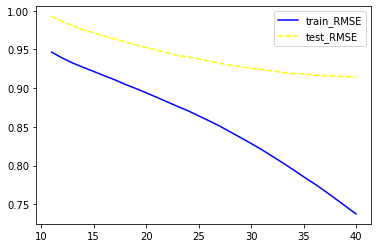

In [5]:
import matplotlib.pyplot as plt

df=pd.DataFrame(model.learning_process[10:], columns=['epoch', 'train_RMSE', 'test_RMSE'])
plt.plot('epoch', 'train_RMSE', data=df, color='blue')
plt.plot('epoch', 'test_RMSE', data=df, color='yellow', linestyle='dashed')
plt.legend()

#### Saving and evaluating recommendations

In [15]:
model.estimations()

top_n=pd.DataFrame(model.recommend(user_code_id, item_code_id, topK=10))

top_n.to_csv('Recommendations generated/ml-100k/Self_SVD_reco.csv', index=False, header=False)

estimations=pd.DataFrame(model.estimate(user_code_id, item_code_id, test_ui))
estimations.to_csv('Recommendations generated/ml-100k/Self_SVD_estimations.csv', index=False, header=False)

In [16]:
import evaluation_measures as ev

estimations_df=pd.read_csv('Recommendations generated/ml-100k/Self_SVD_estimations.csv', header=None)
reco=np.loadtxt('Recommendations generated/ml-100k/Self_SVD_reco.csv', delimiter=',')

ev.evaluate(test=pd.read_csv('./Datasets/ml-100k/test.csv', sep='\t', header=None),
            estimations_df=estimations_df, 
            reco=reco,
            super_reactions=[4,5])

943it [00:00, 4261.36it/s]


RMSE      MAE  precision    recall       F_1      F_05  \
0  0.914521  0.71768   0.102757  0.043043  0.052432  0.069515   

   precision_super  recall_super      NDCG       mAP       MRR      LAUC  \
0         0.094528      0.075122  0.106751  0.051431  0.198701  0.518248   

         HR       HR2  Reco in test  Test coverage   Shannon      Gini  
0  0.462354  0.255567      0.854931       0.147186  3.888926  0.972044

In [17]:
import imp
imp.reload(ev)

import evaluation_measures as ev
dir_path="Recommendations generated/ml-100k/"
super_reactions=[4,5]
test=pd.read_csv('./Datasets/ml-100k/test.csv', sep='\t', header=None)

ev.evaluate_all(test, dir_path, super_reactions)

943it [00:00, 5504.80it/s]
943it [00:00, 4588.89it/s]
943it [00:00, 3546.71it/s]
943it [00:00, 3802.69it/s]
943it [00:00, 3533.79it/s]
943it [00:00, 3587.29it/s]
943it [00:00, 3825.53it/s]
943it [00:00, 3495.58it/s]
943it [00:00, 3725.91it/s]
943it [00:00, 3820.07it/s]
943it [00:00, 3632.69it/s]
943it [00:00, 3564.35it/s]
943it [00:00, 3651.79it/s]
943it [00:00, 3835.91it/s]
943it [00:00, 4391.98it/s]
943it [00:00, 3026.85it/s]
943it [00:00, 2492.44it/s]


Model      RMSE       MAE  precision    recall       F_1  \
0            Self_TopPop  2.508258  2.217909   0.188865  0.116919  0.118732   
0       Self_SVDBaseline  3.642710  3.477031   0.137858  0.083447  0.084155   
0               Self_SVD  0.914521  0.717680   0.102757  0.043043  0.052432   
0         Ready_Baseline  0.949459  0.752487   0.091410  0.037652  0.046030   
0         Self_GlobalAvg  1.125760  0.943534   0.061188  0.025968  0.031383   
0           Ready_Random  1.517593  1.220181   0.046023  0.019038  0.023118   
0            Ready_I-KNN  1.030386  0.813067   0.026087  0.006908  0.010593   
0   Ready_I-KNNWithMeans  0.955921  0.754037   0.004984  0.003225  0.003406   
0  Ready_I-KNNWithZScore  0.957701  0.752387   0.003712  0.001994  0.002380   
0   Self_I-KNNBaseline39  0.935520  0.737631   0.002757  0.000856  0.001230   
0   Self_I-KNNBaseline38  0.935685  0.737828   0.002651  0.000837  0.001197   
0    Ready_I-KNNBaseline  0.935327  0.737424   0.002545  0.000755  0.001105   
0            Ready_U-KNN  1.023495  0.807913   0.000742  0.000205  0.000305   
0          Self_TopRated  2.508258  2.217909   0.000954  0.000188  0.000298   
0        Self_BaselineIU  0.958136  0.754051   0.000954  0.000188  0.000298   
0        Self_BaselineUI  0.967585  0.762740   0.000954  0.000170  0.000278   
0              Self_IKNN  1.018363  0.808793   0.000318  0.000108  0.000140   

       F_05  precision_super  recall_super      NDCG       mAP       MRR  \
0  0.141584         0.130472      0.137473  0.214651  0.111707  0.400939   
0  0.101113         0.108476      0.109680  0.164872  0.083459  0.338033   
0  0.069515         0.094528      0.075122  0.106751  0.051431  0.198701   
0  0.061286         0.079614      0.056463  0.095957  0.043178  0.198193   
0  0.041343         0.040558      0.032107  0.067695  0.027470  0.171187   
0  0.030734         0.029292      0.021639  0.050818  0.019958  0.126646   
0  0.016046         0.021137      0.009522  0.024214  0.008958  0.048068   
0  0.003956         0.004506      0.003861  0.006815  0.002906  0.020332   
0  0.002919         0.003433      0.002401  0.005137  0.002158  0.016458   
0  0.001758         0.002468      0.001048  0.003899  0.001620  0.013296   
0  0.001702         0.002361      0.001020  0.003635  0.001443  0.012589   
0  0.001602         0.002253      0.000930  0.003444  0.001362  0.011760   
0  0.000449         0.000536      0.000198  0.000845  0.000274  0.002744   
0  0.000481         0.000644      0.000223  0.001043  0.000335  0.003348   
0  0.000481         0.000644      0.000223  0.001043  0.000335  0.003348   
0  0.000463         0.000644      0.000189  0.000752  0.000168  0.001677   
0  0.000189         0.000000      0.000000  0.000214  0.000037  0.000368   

       LAUC        HR       HR2  Reco in test  Test coverage   Shannon  \
0  0.555546  0.765642  0.492047      1.000000       0.038961  3.159079   
0  0.538614  0.634146  0.359491      0.999788       0.275613  5.134751   
0  0.518248  0.462354  0.255567      0.854931       0.147186  3.888926   
0  0.515501  0.437964  0.239661      1.000000       0.033911  2.836513   
0  0.509546  0.384942  0.142100      1.000000       0.025974  2.711772   
0  0.506031  0.305408  0.111347      0.988547       0.174603  5.082383   
0  0.499885  0.154825  0.072110      0.402333       0.434343  5.133650   
0  0.497969  0.039236  0.007423      0.587699       0.071429  2.699278   
0  0.497349  0.027572  0.007423      0.389926       0.067821  2.475747   
0  0.496775  0.022269  0.005302      0.483351       0.059885  2.235102   
0  0.496765  0.022269  0.004242      0.483245       0.059163  2.235851   
0  0.496724  0.021209  0.004242      0.482821       0.059885  2.232578   
0  0.496441  0.007423  0.000000      0.602121       0.010823  2.089186   
0  0.496433  0.009544  0.000000      0.699046       0.005051  1.945910   
0  0.496433  0.009544  0.000000      0.699046       0.005051  1.945910   
0  0.496424  0.009544  0.000000      0.6005

### Embeddings

In [9]:
x=np.array([[1,2],[3,4]])
display(x)
x/np.linalg.norm(x, axis=1)[:,None]

array([[1, 2],
       [3, 4]])

array([[0.4472136 , 0.89442719],
       [0.6       , 0.8       ]])

In [10]:
item=random.choice(list(set(train_ui.indices)))

embeddings_norm=model.Qi/np.linalg.norm(model.Qi, axis=1)[:,None] # we do not mean-center here
# omitting normalization also makes sense, but items with a greater magnitude will be recommended more often

similarity_scores=np.dot(embeddings_norm,embeddings_norm[item].T)
top_similar_items=pd.DataFrame(enumerate(similarity_scores), columns=['code', 'score'])\
.sort_values(by=['score'], ascending=[False])[:10]

top_similar_items['item_id']=top_similar_items['code'].apply(lambda x: item_code_id[x])

items=pd.read_csv('./Datasets/ml-100k/movies.csv')

result=pd.merge(top_similar_items, items, left_on='item_id', right_on='id')

result

code     score  item_id    id                               title  \
0  1051  1.000000     1052  1052  Dracula: Dead and Loving It (1995)   
1  1177  0.951303     1178  1178                  Major Payne (1994)   
2  1290  0.950489     1291  1291                 Celtic Pride (1996)   
3  1375  0.949864     1376  1376            Meet Wally Sparks (1997)   
4  1489  0.947375     1490  1490                       Fausto (1993)   
5  1495  0.947368     1496  1496                      Carpool (1996)   
6  1497  0.947347     1498  1498               Farmer & Chase (1995)   
7  1490  0.946829     1491  1491             Tough and Deadly (1995)   
8  1320  0.946152     1321  1321                  Open Season (1996)   
9  1487  0.945425     1488  1488                     Germinal (1993)   

                    genres  
0           Comedy, Horror  
1                   Comedy  
2                   Comedy  
3                   Comedy  
4                   Comedy  
5            Comedy, Crime  
6                   Comedy  
7  Action, Drama, Thriller  
8                   Comedy  
9                    Drama

# project task 5:  implement SVD on top baseline (as it is in Surprise library)

In [11]:
# making changes to our implementation by considering additional parameters in the gradient descent procedure 
# seems to be the fastest option
# please save the output in 'Recommendations generated/ml-100k/Self_SVDBaseline_reco.csv' and
# 'Recommendations generated/ml-100k/Self_SVDBaseline_estimations.csv'

In [24]:
# Done similarly to https://github.com/albertauyeung/matrix-factorization-in-python
from tqdm import tqdm

class SVDBaseline():
    
    def __init__(self, train_ui, learning_rate, regularization, nb_factors, iterations):
        self.train_ui=train_ui
        self.uir=list(zip(*[train_ui.nonzero()[0],train_ui.nonzero()[1], train_ui.data]))
        
        self.learning_rate=learning_rate
        self.regularization=regularization
        self.iterations=iterations
        self.nb_users, self.nb_items=train_ui.shape
        self.nb_ratings=train_ui.nnz
        self.nb_factors=nb_factors
        
        self.Pu=np.random.normal(loc=0, scale=1./self.nb_factors, size=(self.nb_users, self.nb_factors))
        self.Qi=np.random.normal(loc=0, scale=1./self.nb_factors, size=(self.nb_items, self.nb_factors))

        self.b_u = np.zeros(self.nb_users)
        self.b_i = np.zeros(self.nb_items)
        
    def train(self, test_ui=None):
        if test_ui!=None:
            self.test_uir=list(zip(*[test_ui.nonzero()[0],test_ui.nonzero()[1], test_ui.data]))
            
        self.learning_process=[]
        pbar = tqdm(range(self.iterations))
        for i in pbar:
            pbar.set_description(f'Epoch {i} RMSE: {self.learning_process[-1][1] if i>0 else 0}. Training epoch {i+1}...')
            np.random.shuffle(self.uir)
            self.sgd(self.uir)
            if test_ui==None:
                self.learning_process.append([i+1, self.RMSE_total(self.uir)])
            else:
                self.learning_process.append([i+1, self.RMSE_total(self.uir), self.RMSE_total(self.test_uir)])
    
    def sgd(self, uir):
        
        for u, i, score in uir:
            # Computer prediction and error
            prediction = self.get_rating(u,i)
            e = (score - prediction)
            
            
            b_u_update = self.learning_rate * (e - self.regularization * self.b_u[u])
            b_i_update = self.learning_rate * (e - self.regularization * self.b_i[i])
            
            self.b_u[u] += b_u_update
            self.b_i[i] += b_i_update
            # Update user and item latent feature matrices
            Pu_update=self.learning_rate * (e * self.Qi[i] - self.regularization * self.Pu[u])
            Qi_update=self.learning_rate * (e * self.Pu[u] - self.regularization * self.Qi[i])
            
            self.Pu[u] += Pu_update
            self.Qi[i] += Qi_update
        
    def get_rating(self, u, i):
        prediction = self.b_u[u] + self.b_i[i] + self.Pu[u].dot(self.Qi[i].T)
        return prediction
    
    def RMSE_total(self, uir):
        RMSE=0
        for u,i, score in uir:
            prediction = self.get_rating(u,i)
            RMSE+=(score - prediction)**2
        return np.sqrt(RMSE/len(uir))
    
    def estimations(self):
        self.estimations=\
        self.b_u[:,np.newaxis] + self.b_i[np.newaxis:,] + np.dot(self.Pu,self.Qi.T)

    def recommend(self, user_code_id, item_code_id, topK=10):
        
        top_k = defaultdict(list)
        for nb_user, user in enumerate(self.estimations):
            
            user_rated=self.train_ui.indices[self.train_ui.indptr[nb_user]:self.train_ui.indptr[nb_user+1]]
            for item, score in enumerate(user):
                if item not in user_rated and not np.isnan(score):
                    top_k[user_code_id[nb_user]].append((item_code_id[item], score))
        result=[]
        # Let's choose k best items in the format: (user, item1, score1, item2, score2, ...)
        for uid, item_scores in top_k.items():
            item_scores.sort(key=lambda x: x[1], reverse=True)
            result.append([uid]+list(chain(*item_scores[:topK])))
        return result
    
    def estimate(self, user_code_id, item_code_id, test_ui):
        result=[]
        for user, item in zip(*test_ui.nonzero()):
            result.append([user_code_id[user], item_code_id[item], 
                           self.estimations[user,item] if not np.isnan(self.estimations[user,item]) else 1])
        return result

In [25]:
model=SVDBaseline(train_ui, learning_rate=0.005, regularization=0.02, nb_factors=100, iterations=40)
model.train(test_ui)

Epoch 39 RMSE: 0.7820631219900416. Training epoch 40...: 100%|█████████████████████████| 40/40 [03:33<00:00,  5.34s/it]


In [26]:
model.estimations()

top_n=pd.DataFrame(model.recommend(user_code_id, item_code_id, topK=10))

top_n.to_csv('Recommendations generated/ml-100k/Self_SVDBaseline_reco.csv', index=False, header=False)

estimations=pd.DataFrame(model.estimate(user_code_id, item_code_id, test_ui))
estimations.to_csv('Recommendations generated/ml-100k/Self_SVDBaseline_estimations.csv', index=False, header=False)

In [27]:
import evaluation_measures as ev

estimations_df=pd.read_csv('Recommendations generated/ml-100k/Self_SVDBaseline_estimations.csv', header=None)
reco=np.loadtxt('Recommendations generated/ml-100k/Self_SVDBaseline_reco.csv', delimiter=',')

ev.evaluate(test=pd.read_csv('./Datasets/ml-100k/test.csv', sep='\t', header=None),
            estimations_df=estimations_df, 
            reco=reco,
            super_reactions=[4,5])

943it [00:00, 3891.04it/s]


RMSE       MAE  precision    recall       F_1      F_05  \
0  0.913253  0.719475    0.10509  0.043952  0.053454  0.070803   

   precision_super  recall_super      NDCG       mAP       MRR      LAUC  \
0         0.095279      0.073469  0.118152  0.058739  0.244096  0.518714   

         HR       HR2  Reco in test  Test coverage   Shannon      Gini  
0  0.471898  0.279958      0.999682       0.111111  3.572421  0.980655

# Ready-made SVD - Surprise implementation

### SVD

In [12]:
import helpers
import surprise as sp
import imp
imp.reload(helpers)

algo = sp.SVD(biased=False) # to use unbiased version

helpers.ready_made(algo, reco_path='Recommendations generated/ml-100k/Ready_SVD_reco.csv',
          estimations_path='Recommendations generated/ml-100k/Ready_SVD_estimations.csv')

Generating predictions...
Generating top N recommendations...
Generating predictions...


### SVD biased - on top baseline

In [13]:
import helpers
import surprise as sp
import imp
imp.reload(helpers)

algo = sp.SVD() # default is biased=True

helpers.ready_made(algo, reco_path='Recommendations generated/ml-100k/Ready_SVDBiased_reco.csv',
          estimations_path='Recommendations generated/ml-100k/Ready_SVDBiased_estimations.csv')

Generating predictions...
Generating top N recommendations...
Generating predictions...


In [28]:
import imp
imp.reload(ev)

import evaluation_measures as ev
dir_path="Recommendations generated/ml-100k/"
super_reactions=[4,5]
test=pd.read_csv('./Datasets/ml-100k/test.csv', sep='\t', header=None)

ev.evaluate_all(test, dir_path, super_reactions)

943it [00:00, 3972.80it/s]
943it [00:00, 3608.86it/s]
943it [00:00, 3514.94it/s]
943it [00:00, 3447.85it/s]
943it [00:00, 3615.55it/s]
943it [00:00, 3364.78it/s]
943it [00:00, 3508.24it/s]
943it [00:00, 3394.08it/s]
943it [00:00, 3294.51it/s]
943it [00:00, 3636.65it/s]
943it [00:00, 3356.18it/s]
943it [00:00, 3364.83it/s]
943it [00:00, 3438.26it/s]
943it [00:00, 3642.63it/s]
943it [00:00, 3294.49it/s]
943it [00:00, 3205.15it/s]
943it [00:00, 3737.24it/s]
943it [00:00, 3456.46it/s]
943it [00:00, 3528.07it/s]
943it [00:00, 3495.27it/s]
943it [00:00, 3321.11it/s]
943it [00:00, 2405.91it/s]
943it [00:00, 2676.16it/s]


Model      RMSE       MAE  precision    recall       F_1  \
0            Self_TopPop  2.508258  2.217909   0.188865  0.116919  0.118732   
0       Self_SVDBaseline  0.913253  0.719475   0.105090  0.043952  0.053454   
0               Self_SVD  0.914521  0.717680   0.102757  0.043043  0.052432   
0         Ready_Baseline  0.949459  0.752487   0.091410  0.037652  0.046030   
0         Self_GlobalAvg  1.125760  0.943534   0.061188  0.025968  0.031383   
0           Ready_Random  1.517593  1.220181   0.046023  0.019038  0.023118   
0            Ready_I-KNN  1.030386  0.813067   0.026087  0.006908  0.010593   
0   Ready_I-KNNWithMeans  0.955921  0.754037   0.004984  0.003225  0.003406   
0  Ready_I-KNNWithZScore  0.957701  0.752387   0.003712  0.001994  0.002380   
0   Self_I-KNNBaseline45  0.935268  0.737543   0.003075  0.001044  0.001450   
0   Self_I-KNNBaseline42  0.935028  0.737210   0.002969  0.000980  0.001374   
0   Self_I-KNNBaseline43  0.935241  0.737463   0.002863  0.000952  0.001331   
0   Self_I-KNNBaseline44  0.935259  0.737530   0.002969  0.000902  0.001305   
0   Self_I-KNNBaseline39  0.935520  0.737631   0.002757  0.000856  0.001230   
0   Self_I-KNNBaseline38  0.935685  0.737828   0.002651  0.000837  0.001197   
0   Self_I-KNNBaseline41  0.935205  0.737439   0.002651  0.000774  0.001138   
0    Ready_I-KNNBaseline  0.935327  0.737424   0.002545  0.000755  0.001105   
0   Self_I-KNNBaseline40  0.935327  0.737424   0.002545  0.000755  0.001105   
0            Ready_U-KNN  1.023495  0.807913   0.000742  0.000205  0.000305   
0          Self_TopRated  2.508258  2.217909   0.000954  0.000188  0.000298   
0        Self_BaselineIU  0.958136  0.754051   0.000954  0.000188  0.000298   
0        Self_BaselineUI  0.967585  0.762740   0.000954  0.000170  0.000278   
0              Self_IKNN  1.018363  0.808793   0.000318  0.000108  0.000140   

       F_05  precision_super  recall_super      NDCG       mAP       MRR  \
0  0.141584         0.130472      0.137473  0.214651  0.111707  0.400939   
0  0.070803         0.095279      0.073469  0.118152  0.058739  0.244096   
0  0.069515         0.094528      0.075122  0.106751  0.051431  0.198701   
0  0.061286         0.079614      0.056463  0.095957  0.043178  0.198193   
0  0.041343         0.040558      0.032107  0.067695  0.027470  0.171187   
0  0.030734         0.029292      0.021639  0.050818  0.019958  0.126646   
0  0.016046         0.021137      0.009522  0.024214  0.008958  0.048068   
0  0.003956         0.004506      0.003861  0.006815  0.002906  0.020332   
0  0.002919         0.003433      0.002401  0.005137  0.002158  0.016458   
0  0.002016         0.002790      0.001317  0.004287  0.001812  0.014189   
0  0.001929         0.002682      0.001217  0.004069  0.001677  0.013349   
0  0.001862         0.002575      0.001186  0.004014  0.001663  0.013467   
0  0.001880         0.002682      0.001129  0.004215  0.001823  0.013977   
0  0.001758         0.002468      0.001048  0.003899  0.001620  0.013296   
0  0.001702         0.002361      0.001020  0.003635  0.001443  0.012589   
0  0.001658         0.002361      0.000959  0.003537  0.001435  0.011494   
0  0.001602         0.002253      0.000930  0.003444  0.001362  0.011760   
0  0.001602         0.002253      0.000930  0.003444  0.001362  0.011760   
0  0.000449         0.000536      0.000198  0.000845  0.000274  0.002744   
0  0.000481         0.000644      0.000223  0.001043  0.000335  0.003348   
0  0.000481         0.000644      0.000223  0.001043  0.000335  0.003348   
0  0.000463         0.000644      0.000189  0.000752  0.000168  0.001677   
0  0.000189         0.000000      0.000000  0.000214  0.000037  0.000368   

       LAUC        HR       HR2  Reco in test  Test coverage   Shannon  \
0  0.555546  0.765642  0.492047      1.000000       0.038961  3.159079   
0  0.518714  0.471898  0.279958      0.999682       0.111111  3.572421   
0  0.518248  0.462354  0.255567      0.854931       0.147186  3.888926   
0